In [134]:
from openai import Client
from os import getenv

client = Client(
    api_key=getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1"
)

response = client.chat.completions.create(
    # model="deepseek/deepseek-r1",
    # model="anthropic/claude-3.7-sonnet:thinking",
    model="anthropic/claude-sonnet-4",
    # model="google/gemini-2.5-flash-preview-05-20:thinking",
    # model="mistralai/magistral-medium-2506:thinking",
    # model="openai/o4-mini",
    messages=[
        {"role": "user", "content": "What is the capital of France?"}
    ],
    extra_body={"include_reasoning": True, "reasoning_effort": "low"}
)

In [ ]:
print("===Reasoning===")
print(response.choices[0].message.reasoning)
print("===Answer===")
print(response.choices[0].message.content)


In [129]:
response.model_dump()

{'id': 'gen-1750360842-F2gEngdV6aRTu1kCMrz8',
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'logprobs': None,
   'message': {'content': 'The capital of France is Paris.',
    'refusal': None,
    'role': 'assistant',
    'annotations': None,
    'audio': None,
    'function_call': None,
    'tool_calls': None,
    'reasoning': "This is a straightforward factual question. The capital of France is Paris. This is basic geography knowledge that I'm confident about.",
    'reasoning_details': [{'type': 'reasoning.text',
      'text': "This is a straightforward factual question. The capital of France is Paris. This is basic geography knowledge that I'm confident about.",
      'signature': 'ErMCCkgIBBACGAIqQCkH/2/r5RnhmRPpeQJHPH4xu3wLTFTJ6Irb+MOenCiTfRIN2Biyn2RaEusPU0lyhAsv8KdupmrUE3Eya6WjK/8SDBCpGxSJkOB28rWt/BoMvVcdqQFgxVKRfoCMIjBjzxP4faWk08c5tcFb0u1Xnp6osxVfasefr6nHZRr5/oDM5YoKdTUKK0S+BBbWrBQqmAFB/xyhQWoXqIqskCUp1R3wr/eTvFWobOC4RCPYO0N96KlVierMNkYzzhuE3WVbfQfqoWuhl74d/FcVeGrAdEx

In [103]:
import pandas as pd
from openai import Client
from os import getenv
from tqdm import tqdm

client = Client(
    api_key=getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1"
)

def run_question_across_models(question: str, answer: str) -> pd.DataFrame:
    models = [
        "openai/gpt-3.5-turbo",
        "openai/o4-mini",
        "openai/o4-mini-high",
        "openai/o3",
        "deepseek/deepseek-r1",
        "anthropic/claude-3.7-sonnet:thinking",
        "anthropic/claude-sonnet-4",
        "google/gemini-2.5-flash-preview-05-20:thinking",
        "mistralai/magistral-medium-2506:thinking"
    ]
    
    results = []
    
    for model in tqdm(models):
        for reasoning_effort in ["low", "medium", "high", None]:
            try:
                body = {"include_reasoning": True}
                if reasoning_effort is not None:
                    body['reasoning_effort'] = reasoning_effort
                response = client.chat.completions.create(
                    model=model,
                    messages=[{"role": "user", "content": question}],
                    extra_body=body
                )
                reasoning = getattr(response.choices[0].message, "reasoning", None)
                content = response.choices[0].message.content
            except Exception as e:
                reasoning = f"Error: {e}"
                content = "N/A"
            
            results.append({
                "model": model,
                "reasoning": reasoning,
                "answer": content,
                "reasoning_effort": reasoning_effort,
                "correct": answer in content
            })
    
    return pd.DataFrame(results)


In [104]:
results_df = run_question_across_models(
    question="which is bigger, pi * 28.5 or 89? Output the final answer in a box so either [pi * 28.5] or [89]",
    answer="[pi * 28.5]"
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [08:10<00:00, 54.48s/it]


In [105]:
# confirming 3.5 has no reasoning
results_df[results_df['model'] == 'openai/gpt-3.5-turbo']

,model,reasoning,answer,reasoning_effort,correct
0,openai/gpt-3.5-turbo,None,[pi * 28.5],low,True
1,openai/gpt-3.5-turbo,None,[89],medium,False
2,openai/gpt-3.5-turbo,None,[pi * 28.5],high,True
3,openai/gpt-3.5-turbo,None,[pi * 28.5],None,True


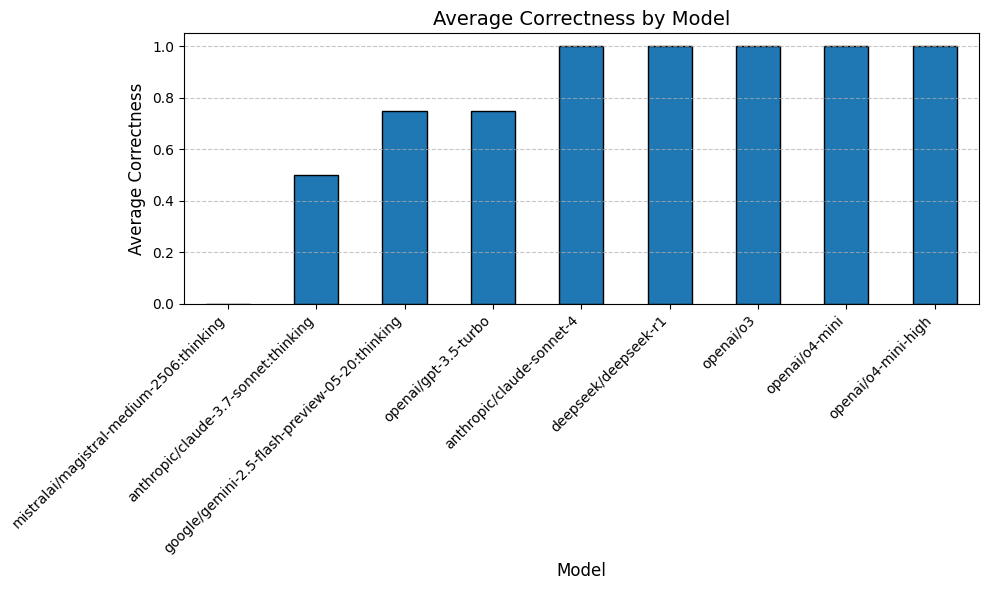

In [108]:
import matplotlib.pyplot as plt

# Group by model and calculate mean correctness
model_means = results_df.groupby('model')['correct'].mean().sort_values()

# Plot
plt.figure(figsize=(10, 6))
model_means.plot(kind='bar', edgecolor='black')

# Title and labels
plt.title('Average Correctness by Model', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Average Correctness', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [78]:
question = "which is bigger, pi * 28.5 or 90?"

def do_req(model, content, include_reasoning=False):
    return client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": content}],
        extra_body={"include_reasoning": include_reasoning} if include_reasoning else {}
    )

# Step 1: Get reasoning only using R1
content = f"{question} Please think this through, but don't output the answer - only think about the problem, and output 'done' when you have thought about it enough."
reasoning_response = do_req("deepseek/deepseek-r1", content, include_reasoning=True)
reasoning = reasoning_response.choices[0].message.reasoning

print("===Reasoning (From DeepSeek) ===")
print(reasoning)

# Step 2: Baseline model without reasoning
simple_response = do_req("openai/gpt-3.5-turbo", question)
print("===Simple Answer===")
print(simple_response.choices[0].message.content)

# Step 3: Give it the reasoning and ask again
context_prompt = f"{question}. Here is some context to help you: {reasoning}"
smart_response = do_req("openai/gpt-3.5-turbo", context_prompt)
print("===Answer with R1 Reasoning===")
print(smart_response.choices[0].message.content)


===Reasoning (From DeepSeek) ===
Okay, let's see. The question is asking whether π multiplied by 28 is bigger than 90. Hmm, I need to figure this out step by step.

First, I know that π is approximately 3.1416. So if I multiply that by 28, what do I get? Let me do the calculation. 28 times 3 is 84, right? Then 28 times 0.1416 would be... let's see, 0.1 times 28 is 2.8, and 0.0416 times 28. Let me calculate 0.04 times 28 first, which is 1.12, and 0.0016 times 28 is 0.0448. Adding those together: 1.12 + 0.0448 = 1.1648. So adding that to the 2.8 from before gives 2.8 + 1.1648 = 3.9648. So the total would be 84 (from the 3) plus 3.9648, which is 87.9648. Wait, that's π times 28. So π*28 ≈ 87.96, which is less than 90. So 90 is bigger?

But wait, maybe I should check my math again to be sure. Let me try another way. Maybe approximate π as 22/7, which is a common approximation. So 22/7 times 28. The 28 and 7 would cancel out, leaving 22*4 = 88. So that's 88. Since 22/7 is a slight underesti